In [1]:
#%%
import numpy as np
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from typing import List
import random
from shared import bootstrap_auc
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

In [2]:
# start off by seeding random number generators:
RANDOM_SEED = 12345
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
# import data; choose feature space
from dataset_poetry import y_train, Xd_train, y_vali, Xd_vali

X_train = Xd_train["numeric"]
X_vali = Xd_vali["numeric"]

In [4]:
#%%
from sklearn.linear_model import LogisticRegression

m = LogisticRegression(random_state=RANDOM_SEED, penalty="none", max_iter=2000)
m.fit(X_train, y_train)

print("skLearn-LR AUC: {:.3}".format(np.mean(bootstrap_auc(m, X_vali, y_vali))))
print("skLearn-LR Acc: {:.3}".format(m.score(X_vali, y_vali)))

skLearn-LR AUC: 0.975
skLearn-LR Acc: 0.929


In [5]:
def nearly_eq(x, y, tolerance=1e-6):
    return abs(x - y) < tolerance


#%%


(N, D) = X_train.shape

X = torch.from_numpy(X_train).float()
y = torch.from_numpy(y_train).long()
Xv = torch.from_numpy(X_vali).float()
yv = torch.from_numpy(y_vali).long()


def train(name: str, model, optimizer, objective, max_iter=2000):
    train_losses = []
    vali_losses = []
    samples = []
    for it in tqdm(range(max_iter)):
        model.train()

        # Perform one step of training:
        optimizer.zero_grad()
        loss = objective(model(X), y)
        loss.backward()
        optimizer.step()

        # every 25 steps, sample validation performance.
        if it % 25 == 0:
            model.eval()
            y_probs = model(X).detach().numpy()
            vali_loss = objective(model(Xv), yv)
            train_losses.append(loss.item())
            vali_losses.append(vali_loss.item())
            samples.append(it)
    model.eval()

    # Predict on the Validation Set
    y_probs = model(Xv).detach().numpy()
    y_pred = (y_probs[:, 1] > 0.5).ravel()
    print(
        "Validation. Acc: {:.3} Auc: {:.3}".format(
            metrics.accuracy_score(yv, y_pred),
            metrics.roc_auc_score(yv, y_probs[:, 1].ravel()),
        )
    )

    plt.plot(samples, train_losses, label="Training Loss", alpha=0.7)
    plt.plot(samples, vali_losses, label="Validation Loss", alpha=0.7)
    plt.title("{} Training Loss".format(name))
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig("graphs/p13-{}-loss.png".format(name))
    plt.show()

    return model

100%|██████████| 2000/2000 [00:01<00:00, 1365.75it/s]


Validation. Acc: 0.927 Auc: 0.972


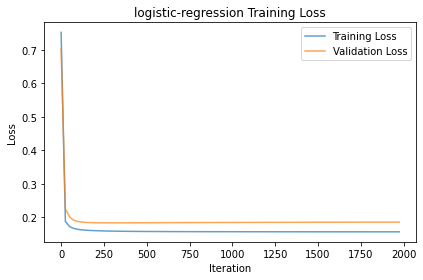

Linear(in_features=38, out_features=2, bias=True)

In [6]:
# Actually train a LogisticRegression; just one 'Linear' layer.
n_classes = len([0, 1])
model = nn.Linear(D, n_classes, bias=True)
objective = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

train("logistic-regression", model, optimizer, objective)

In [7]:
def make_neural_net(D: int, hidden: List[int], num_classes: int = 2, dropout=0.2):
    """ Using nn.Sequential; construct a list of layers that make this a neural-network. """
    layers = []
    for i, dim in enumerate(hidden):
        if i == 0:
            layers.append(nn.Linear(D, dim))
            layers.append(nn.Dropout(p=DROPOUT))
            layers.append(nn.ReLU())
        else:
            layers.append(nn.Linear(hidden[i - 1], dim))
            layers.append(nn.Dropout(p=DROPOUT))
            layers.append(nn.ReLU())
    layers.append(nn.Linear(hidden[-1], num_classes))
    return nn.Sequential(*layers)

### Lab TODO:
### 0. In this version; consider commenting out other calls to train/fit!

### 1. Investigate LEARNING_RATE, DROPOUT, MOMENTUM, REGULARIZATION.

LEARNING_RATE = 0.1  
DROPOUT = 0.1  # randomly turn off this fraction of the neural-net while training.  
MOMENTUM = 0.9  
REGULARIZATION = 0.01   

achieved: Validation. Acc: 0.927 Auc: 0.973  
and converged in the fewest iterations  
learning rate of 1 was too large it definitely was missing the global minimum     


### 2. What do you think these variables change?

Learning rate - 
The amount that the weights are updated during training is referred to as the step size or the “learning rate.”
The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.  

Dropout - A single model can be used to simulate having a large number of different network architectures by randomly dropping out nodes during training. This is called dropout and offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks of all kinds.  
 
Momentum - replaces the current gradient with m (“momentum”), which is an aggregate of gradients. This aggregate is the exponential moving average of current and past gradients (i.e. up to time t).
If the momentum term is large then the learning rate should be kept smaller. A large value of momentum also means that the convergence will happen fast. But if both the momentum and learning rate are kept at large values, then you might skip the minimum with a huge step.  

regularization - neural networks are easily overfit. regularization makes it so neural networks generalize better  

### 3. Consider a shallower, wider network.
###    - Changing [16,16] to something else... might require revisiting step 1.


Comparison   
LEARNING_RATE = 0.1  
DROPOUT = 0.1 # randomly turn off this fraction of the neural-net while training.  
MOMENTUM = 0.9   
REGULARIZATION = 0.01  
[16,16]  
achieved: Validation. Acc: 0.927 Auc: 0.973  


shallower network -   
[1,1] - accuracy decreased to 0.683  
[2,2] - accuracy decreased to .683 auc decreased a little bit  
[5,5] - didn't make much of a difference
[10,10] - didn't make much of a difference  

wider -  
[20,20] - didn't make much of a difference  
[100,100] didn't make much of a difference  


100%|██████████| 1000/1000 [00:01<00:00, 791.83it/s]


Validation. Acc: 0.929 Auc: 0.973


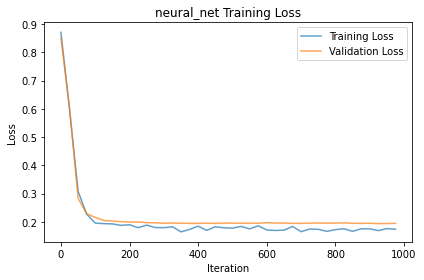

Sequential(
  (0): Linear(in_features=38, out_features=5, bias=True)
  (1): Dropout(p=0.1, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=5, out_features=5, bias=True)
  (4): Dropout(p=0.1, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=2, bias=True)
)

In [52]:
LEARNING_RATE = 0.1
DROPOUT = 0.1  # randomly turn off this fraction of the neural-net while training.
MOMENTUM = 0.9
REGULARIZATION = 0.01  # try 0.1, 0.01, etc.

# two hidden layers, 16 nodes, each.
model = make_neural_net(D, [5, 5], dropout=DROPOUT)
objective = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=REGULARIZATION
)

train("neural_net", model, optimizer, objective, max_iter=1000)